In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy import spatial
from scipy import stats
from scipy.stats import linregress

# Load and clean data

In [2]:
df = pd.read_csv('davis-data.csv')

In [3]:
df.head()

,Player,Pos,Age,Tm,STL,BLK,PF,STL%,BLK%,DWS,DWS/48,DBPM,DFGM,DFGA,DFG%,DRTG
0,Steven Adams,big,25,OKC,1.5,1.0,2.6,2.0,2.4,4.0,0.071937,2.1,3.7,6.2,60.0,105.9
1,Bam Adebayo,big,21,MIA,0.9,0.8,2.5,1.8,3.0,3.4,0.085311,3.6,1.6,2.8,58.7,104.5
2,LaMarcus Aldridge,big,33,SAS,0.5,1.3,2.2,0.8,3.4,2.9,0.051805,0.5,2.3,4.1,55.7,111.0
3,Jarrett Allen,big,20,BRK,0.5,1.5,2.3,1.0,4.5,3.3,0.075573,3.2,3.3,6.0,55.1,111.6
4,Al-Farouq Aminu,big,28,POR,0.8,0.4,1.8,1.4,1.2,2.8,0.058639,0.8,2.1,3.2,66.0,108.2


# Create DAVIS calculator

In [4]:
pos_features = ['STL', 'BLK', 'STL%', 'BLK%', 'DFGA', 'DWS', 'DBPM']
neg_features = ['DRTG']

In [5]:
def calc_dist(pos, neg, df):
    
    features = pos + neg
    
    df_norm = df.copy()
    df_norm[features] = MinMaxScaler().fit_transform(df_norm[features])
    
    max_good = list(df_norm[pos].max().values)
    min_bad = list(df_norm[neg].min().values)
    best_values = max_good + min_bad

    euclid = []
    manhat = []
    wasser = []
    
    for index, row in df_norm.iterrows():
        euclid.append(spatial.distance.euclidean(row[features], best_values))
        manhat.append(spatial.distance.cityblock(row[features], best_values))
        wasser.append(stats.wasserstein_distance(row[features], best_values))
        
    dist_df = pd.DataFrame(zip(df['Player'], euclid, manhat, wasser), columns = ['player', 'euclid', 'manhat', 'wasser'])
    dist_df[['euclid', 'manhat', 'wasser']] = MinMaxScaler().fit_transform(dist_df[['euclid', 'manhat', 'wasser']])
    
    dist_df['davis'] = (dist_df['euclid'] + dist_df['manhat'] + dist_df['wasser']) / 3
    dist_df['davis'] *= -1
    dist_df['davis'] += 1
    dist_df['pos'] = df['Pos']
        
    dist_df = dist_df.sort_values(by = 'davis', ascending = False).reset_index(drop = True)
    return(dist_df)

In [6]:
davis = calc_dist(pos_features, neg_features, df)

# Plot DAVIS results

In [7]:
def plot_davis(df, posname, label_height, fname):
    
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots()
    
    df = df.sort_values(by = 'davis', ascending = False)
    
    y = df['davis'][0:10].values
    x = np.arange(len(y))
    
    ax.bar(x, y, color = 'skyblue', edgecolor = 'white', linewidth = 4.5)
    ax.xaxis.set_visible(False)
    ax.set_ylabel("DAVIS")
    
    labels = df['player'].values

    rects = ax.patches
    for rect, label in zip(rects, labels):
        ax.text(rect.get_x() + rect.get_width() / 1.75, label_height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
        
    fig.suptitle("DAVIS ranking for %s" % (posname + "s"), size = 18, weight = 'bold', y = 1.005)
    ax.set_title('1 = best possible DAVIS', size = 14, fontname = 'Rockwell')
    
    fig.text(x = -0.03, y = 0.02,
        s = '____________________________________________________________',
        fontsize = 14, color = 'grey', horizontalalignment='left', alpha = .3)

    fig.text(x = -0.03, y = -.04,
        s = 'https://dribbleanalytics.blog                     ',
        fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')
    
    fig.savefig('%s.png' % fname, dpi = 400, bbox_inches = 'tight')

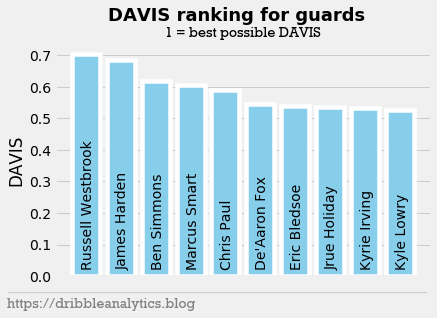

In [8]:
plot_davis(davis[davis['pos'] == 'guard'], 'guard', .02, 'davis-gaurds')

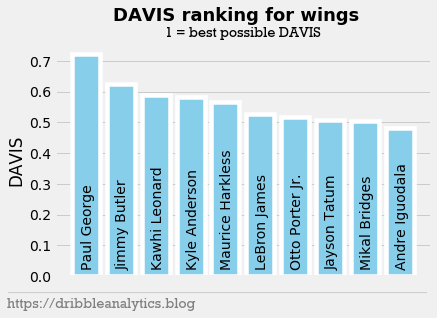

In [9]:
plot_davis(davis[davis['pos'] == 'wing'], 'wing', .02, 'davis-wings')

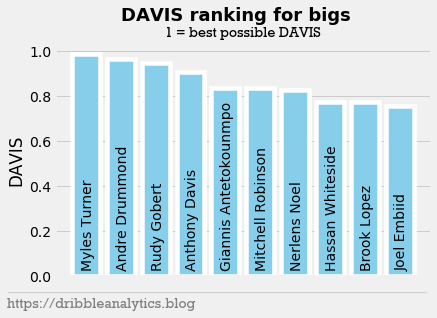

In [10]:
plot_davis(davis[davis['pos'] == 'big'], 'big', .025, 'davis-bigs')

# Compare DAVIS to DWS, DBPM, and DRPM

In [11]:
df = df.rename(columns = {"Player" : "player"})
davis_adv = pd.merge(davis[['player', 'pos', 'davis']], df[['player', 'DWS', 'DBPM']], how = 'inner')

rpm = pd.read_csv('espn-rpm.csv')
davis_rpm = pd.merge(davis[['player', 'pos', 'davis']], rpm[['player', 'drpm']], how = 'inner')

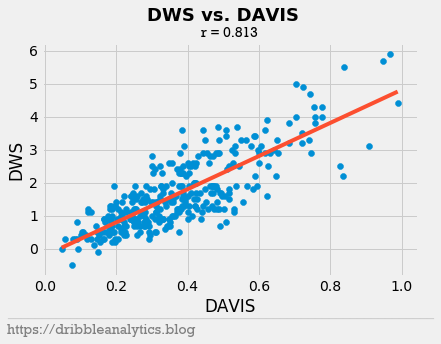

In [12]:
plt.style.use('fivethirtyeight')
davis_dws_scat, ax = plt.subplots()

x = davis_adv['davis']
y = davis_adv['DWS']

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'C1')

ax.set_xlabel("DAVIS")
ax.set_ylabel("DWS")

slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
ax.set_title("r = %s" %str(round(r_value, 3)), size = 14, fontname = 'Rockwell')
davis_dws_scat.suptitle('DWS vs. DAVIS', size = 18, weight = 'bold', y = 1.005)

davis_dws_scat.text(x = 0, y = -0.07,
    s = '_____________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left', alpha = .3)

davis_dws_scat.text(x = 0, y = -.13,
    s = 'https://dribbleanalytics.blog                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')
    
davis_dws_scat.savefig('davis_dws.png', dpi = 400, bbox_inches = 'tight')

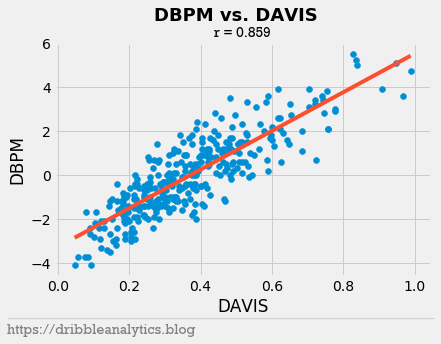

In [13]:
plt.style.use('fivethirtyeight')
davis_dbpm_scat, ax = plt.subplots()

x = davis_adv['davis']
y = davis_adv['DBPM']

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'C1')

ax.set_xlabel("DAVIS")
ax.set_ylabel("DBPM")

slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
ax.set_title("r = %s" %str(round(r_value, 3)), size = 14, fontname = 'Rockwell')
davis_dbpm_scat.suptitle('DBPM vs. DAVIS', size = 18, weight = 'bold', y = 1.005)

davis_dbpm_scat.text(x = -0.03, y = -0.07,
    s = '_____________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left', alpha = .3)

davis_dbpm_scat.text(x = -0.03, y = -.13,
    s = 'https://dribbleanalytics.blog                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')
    
davis_dbpm_scat.savefig('davis_dbpm.png', dpi = 400, bbox_inches = 'tight')

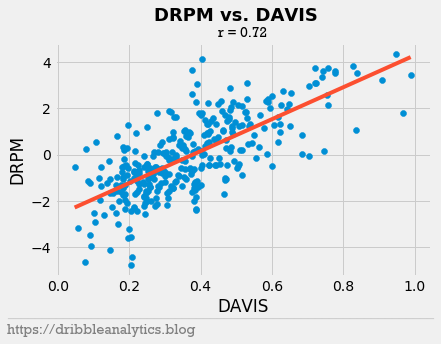

In [14]:
plt.style.use('fivethirtyeight')
davis_rpm_scat, ax = plt.subplots()

x = davis_rpm['davis']
y = davis_rpm['drpm']

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'C1')

ax.set_xlabel("DAVIS")
ax.set_ylabel("DRPM")

slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
ax.set_title("r = %s" %str(round(r_value, 3)), size = 14, fontname = 'Rockwell')
davis_rpm_scat.suptitle('DRPM vs. DAVIS', size = 18, weight = 'bold', y = 1.005)

davis_rpm_scat.text(x = -0.03, y = -0.07,
    s = '_____________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left', alpha = .3)

davis_rpm_scat.text(x = -0.03, y = -.13,
    s = 'https://dribbleanalytics.blog                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')
    
davis_rpm_scat.savefig('davis_drpm.png', dpi = 400, bbox_inches = 'tight')

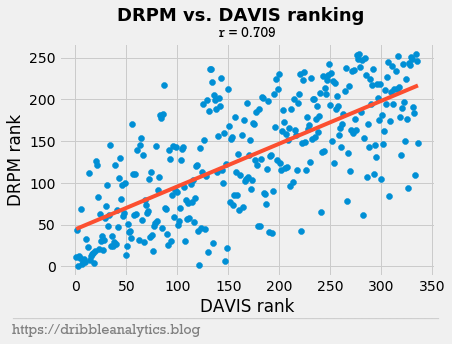

In [15]:
plt.style.use('fivethirtyeight')
davis_rpm__rank_scat, ax = plt.subplots()

davis_rpm['davis_rank'] = davis_rpm['davis'].rank(ascending = False, method = 'dense')
davis_rpm['drpm_rank'] = davis_rpm['drpm'].rank(ascending = False, method = 'dense')

x = davis_rpm['davis_rank']
y = davis_rpm['drpm_rank']

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'C1')

ax.set_xlabel("DAVIS rank")
ax.set_ylabel("DRPM rank")

slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
ax.set_title("r = %s" %str(round(r_value, 3)), size = 14, fontname = 'Rockwell')
davis_rpm__rank_scat.suptitle('DRPM vs. DAVIS ranking', size = 18, weight = 'bold', y = 1.005)

davis_rpm__rank_scat.text(x = -0.03, y = -0.07,
    s = '_____________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left', alpha = .3)

davis_rpm__rank_scat.text(x = -0.03, y = -.13,
    s = 'https://dribbleanalytics.blog                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')
    
davis_rpm__rank_scat.savefig('davis_drpm_rank.png', dpi = 400, bbox_inches = 'tight')

In [16]:
davis_rpm['drpm_diff'] = davis_rpm['davis_rank'] - davis_rpm['drpm_rank']

davis_rpm.sort_values(by = 'drpm_diff')

,player,pos,davis,drpm,davis_rank,drpm_rank,drpm_diff
86,Bradley Beal,guard,0.465109,-1.71,87.0,217.0,-130.0
55,Justin Holiday,guard,0.516603,-0.89,56.0,171.0,-115.0
33,Montrezl Harrell,big,0.600917,-0.50,34.0,145.0,-111.0
19,Russell Westbrook,guard,0.703653,-0.08,20.0,126.0,-106.0
131,Marvin Bagley III,big,0.387776,-2.37,132.0,236.0,-104.0
132,T.J. McConnell,guard,0.386755,-2.40,133.0,237.0,-104.0
20,James Harden,guard,0.684701,0.02,21.0,121.0,-100.0
12,JaVale McGee,big,0.746480,0.16,13.0,112.0,-99.0
82,Luka Doncic,guard,0.470978,-1.07,83.0,181.0,-98.0
85,Shai Gilgeous-Alexander,guard,0.468287,-1.10,86.0,182.0,-96.0


In [17]:
davis_adv.columns.values

array(['player', 'pos', 'davis', 'DWS', 'DBPM'], dtype=object)

In [18]:
final = pd.merge(davis_rpm, davis_adv[['player', 'DWS', 'DBPM']], how = 'inner', on = ['player'])

In [19]:
final.to_csv('davis-rank.csv', index = None)